## Titanic - Machine Learning from Disaster

### **Business Understanding**

<img src="img_titanic.png" width="300"/>

Objective: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.


### **Data Understanding**

| Nº  | Coluna        | Tipo     | Significado.                                                                     |
|-----|---------------|----------|----------------------------------------------------------------------------------|
| 0   | PassengerId   | int64    | ID do passageiro – número único para identificar cada pessoa                    |
| 1   | Survived      | int64    | Sobreviveu – `0 = não sobreviveu`, `1 = sobreviveu`                             |
| 2   | Pclass        | int64    | Classe da passagem – `1 = 1ª classe`, `2 = 2ª classe`, `3 = 3ª classe`          |
| 3   | Name          | object   | Nome completo do passageiro                                                     |
| 4   | Sex           | object   | Sexo – `male = homem`, `female = mulher`                                        |
| 5   | Age           | float64  | Idade – idade do passageiro (possui valores ausentes)                          |
| 6   | SibSp         | int64    | Número de irmãos e/ou cônjuge a bordo                                           |
| 7   | Parch         | int64    | Número de pais e/ou filhos a bordo                                              |
| 8   | Ticket        | object   | Número da passagem                                                              |
| 9   | Fare          | float64  | Tarifa paga pela passagem                                                       |
| 10  | Cabin         | object   | Código da cabine – muitos valores ausentes                                      |
| 11  | Embarked      | object   | Porto de embarque – `S = Southampton`, `C = Cherbourg`, `Q = Queenstown`        |

Bibliotecas

In [1]:
# Bibliotecas para os dados
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Bibliotecas da Modelagem
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Bibliotecas dos Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

Entendendo os dados de treino

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


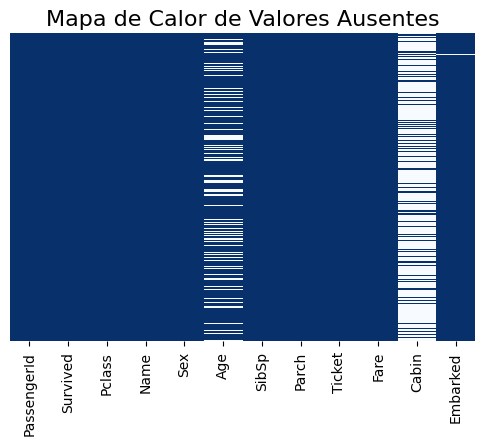

In [5]:
plt.figure(figsize=(6, 4))
sns.heatmap(df_train.isnull(), cbar=False, cmap='Blues_r', yticklabels=False)
plt.title('Mapa de Calor de Valores Ausentes', fontsize=16)
plt.show()

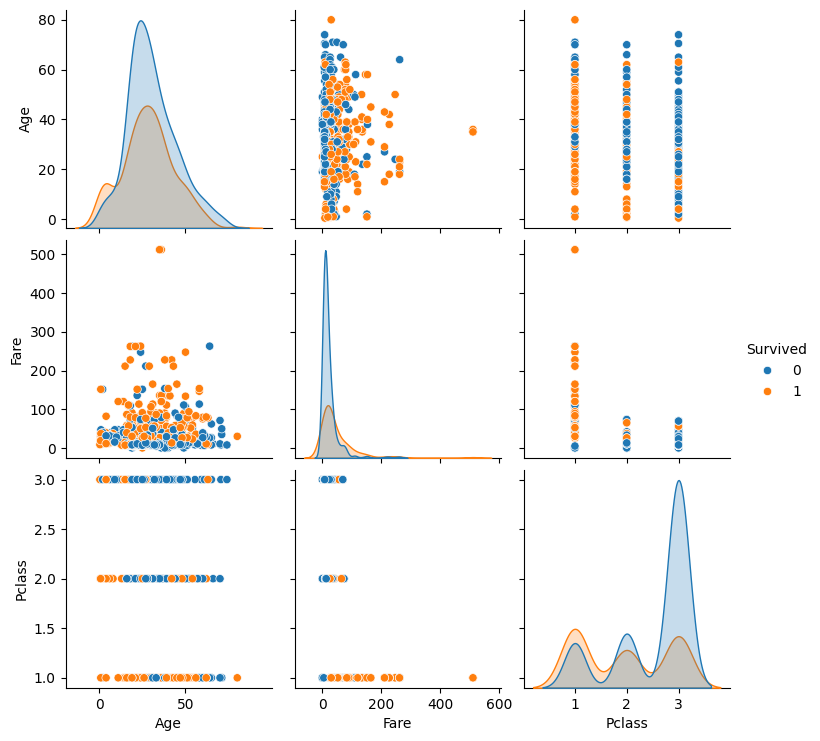

In [6]:
#Analisando as colunas categoricas
sns.pairplot(df_train[['Age', 'Fare', 'Pclass', 'Survived']], hue='Survived')
plt.show()

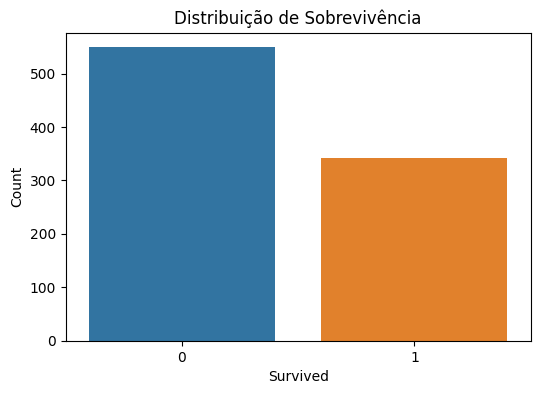

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', hue='Survived', data=df_train, palette={0: '#1f77b4', 1: '#ff7f0e'}, legend=False)
plt.title('Distribuição de Sobrevivência')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

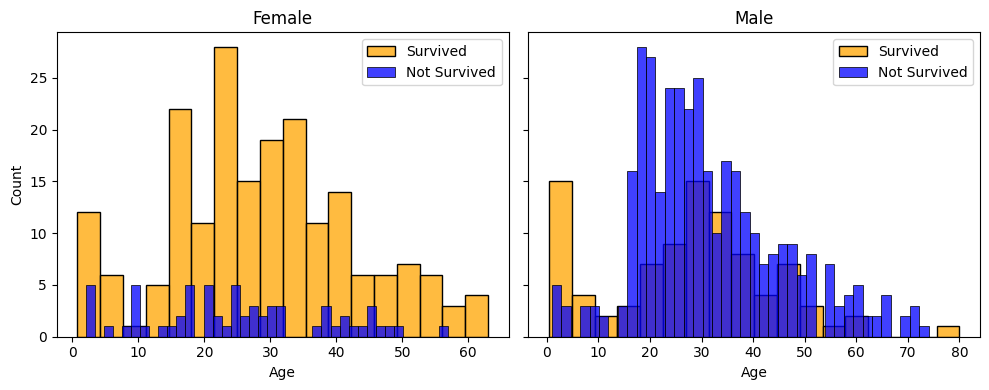

In [8]:
survived = 'Survived'
not_survived = 'Not Survived'

# Separando os dados por sexo
women = df_train[df_train['Sex'] == 'female']
men = df_train[df_train['Sex'] == 'male']

# Criando a figura com dois gráficos lado a lado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

# Mulheres
sns.histplot(women[women['Survived'] == 1]['Age'].dropna(), bins=18, label=survived,
             ax=axes[0], color="orange", kde=False, stat='count')
sns.histplot(women[women['Survived'] == 0]['Age'].dropna(), bins=40, label=not_survived,
             ax=axes[0], color="blue", kde=False, stat='count')
axes[0].legend()
axes[0].set_title('Female')

# Homens
sns.histplot(men[men['Survived'] == 1]['Age'].dropna(), bins=18, label=survived,
             ax=axes[1], color="orange", kde=False, stat='count')
sns.histplot(men[men['Survived'] == 0]['Age'].dropna(), bins=40, label=not_survived,
             ax=axes[1], color="blue", kde=False, stat='count')
axes[1].legend()
axes[1].set_title('Male')

plt.tight_layout()
plt.show()

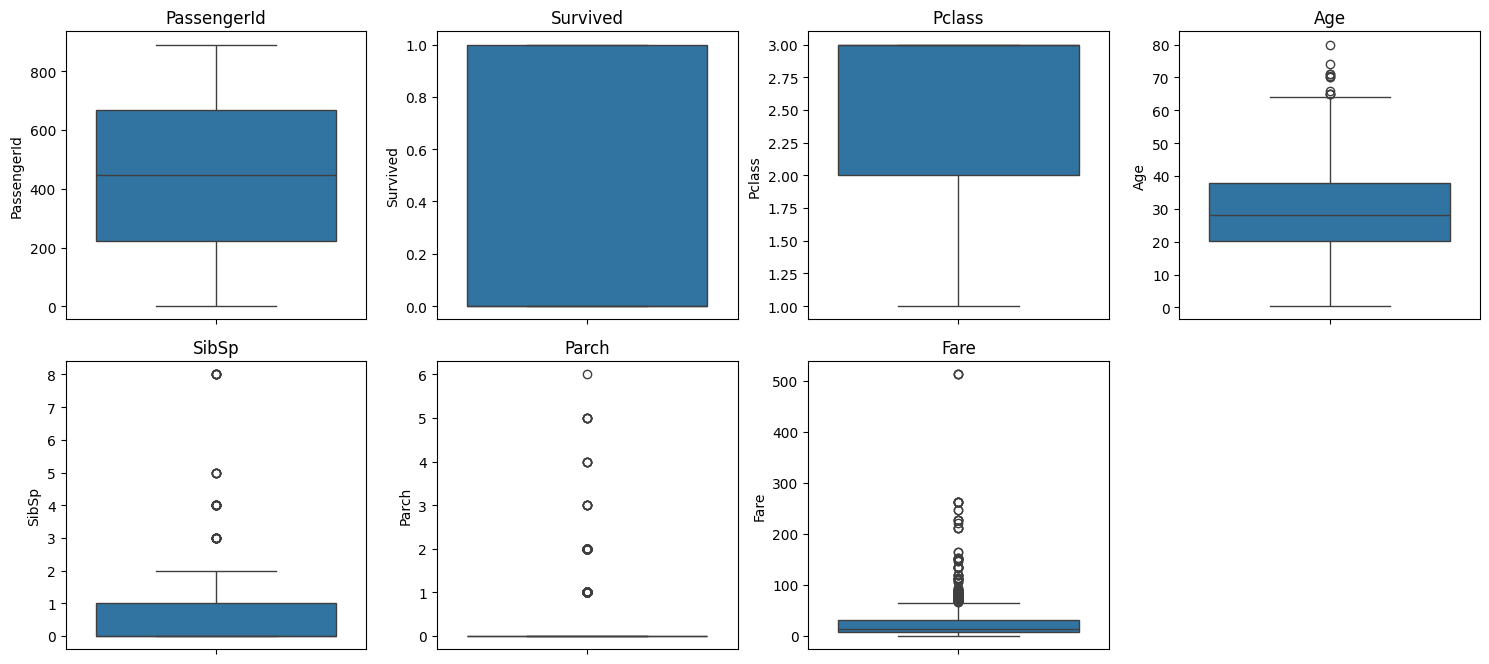

In [ ]:
# Seleciona somente colunas numéricas
numericas = df_train.select_dtypes(include=['int64', 'float64'])

# Cria um gráfico para cada variável numérica
plt.figure(figsize=(15, 10))
for i, coluna in enumerate(numericas.columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df_train[coluna])
    plt.title(coluna)

plt.tight_layout()
plt.show()

### **Data Preparation**

In [10]:
# Verificando valores duplicados
duplicate_numbers = df_train.duplicated().sum()
duplicate_numbers

np.int64(0)

**Sex**

In [ ]:
# Criando uma nova coluna para armazenar os valores numéricos da coluna 'Sex'
df_train['Sex_encoded'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_train['Sex_encoded'].value_counts()

Sex_encoded
0    577
1    314
Name: count, dtype: int64

**Age**

In [12]:
# Verificando os valores nulos da coluna 'Age'
df_train[df_train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encoded
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,1
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,0
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,1
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,0
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,0


In [13]:
# Agrupa e calcula a média com base na classe para preencher os valores ausentes 
# em 'Age'
average_by_sex = df_train.groupby(['Sex','Pclass'])['Age'].transform('mean')
df_train['Age'] = df_train['Age'].fillna(average_by_sex)

**Fare**

In [14]:
df_train[df_train['Fare'] == 0.00][['PassengerId', 'Pclass', 'Sex', 'Age']]

,PassengerId,Pclass,Sex,Age
179,180,3,male,36.000000
263,264,1,male,40.000000
271,272,3,male,25.000000
277,278,2,male,30.740707
302,303,3,male,19.000000
413,414,2,male,30.740707
466,467,2,male,30.740707
481,482,2,male,30.740707
597,598,3,male,49.000000
633,634,1,male,41.281386


In [15]:
for pclass in [1, 2, 3]:
    for sex in ['male', 'female']:
        media_fare = df_train[
            (df_train['Pclass'] == pclass) &
            (df_train['Sex'] == sex) &
            (df_train['Fare'] > 0)
        ]['Fare'].mean()
        
        df_train.loc[
            (df_train['Pclass'] == pclass) &
            (df_train['Sex'] == sex) &
            (df_train['Fare'] == 0),
            'Fare'
        ] = media_fare

**Cabin**

In [16]:
# Verificando os valores nulos da coluna 'Cabin'
df_train[df_train['Cabin'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encoded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0
5,6,0,3,"Moran, Mr. James",male,26.507589,0,0,330877,8.4583,NaN,Q,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,SOTON/OQ 392076,7.0500,NaN,S,0
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,382652,29.1250,NaN,Q,1
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.750000,1,2,W./C. 6607,23.4500,NaN,S,1


In [17]:
# Analisando os valores da coluna 'Cabin'
df_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [18]:
# Extrai a primeira letra da cabine, preenche os nulos com 'U' e codifica com LabelEncoder
df_train['CabinLetter_encoded'] = LabelEncoder().fit_transform(df_train['Cabin'].fillna('U').str[0])

**Embarked**

In [19]:
# Verificando os valores nulos da coluna 'Embarked'
df_train[df_train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encoded,CabinLetter_encoded
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,1


In [20]:
# Analisando a contagem dos valores da coluna 'Cabin'
df_train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [21]:
# LabelEncoder em uma nova coluna, com os NaNs preenchidos diretamente no pipeline
le = LabelEncoder()
df_train['Embarked_encoded'] = le.fit_transform(df_train['Embarked'].fillna('S'))

**Name**

In [22]:
# Extrair o título do nome
df_train['Title'] = df_train['Name'].str.extract(r',\s*([^\.]*)\.')

In [ ]:
# Agrupar títulos semelhantes e reduzir ruído
title_mapping = {
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Lady': 'Rare',
    'Countess': 'Rare',
    'the Countess': 'Rare',
    'Capt': 'Rare',
    'Col': 'Rare',
    'Don': 'Rare',
    'Dr': 'Rare',
    'Major': 'Rare',
    'Rev': 'Rare',
    'Sir': 'Rare',
    'Jonkheer': 'Rare',
    'Dona': 'Rare'
}


df_train['Title'] = df_train['Title'].replace(title_mapping)

In [24]:
df_train['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

In [25]:
le = LabelEncoder()
df_train['Title_encoded'] = le.fit_transform(df_train['Title'])

**SibSp & Parch**

In [26]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1

In [27]:
df_train['IsAlone'] = (df_train['FamilySize'] == 1).astype(int)

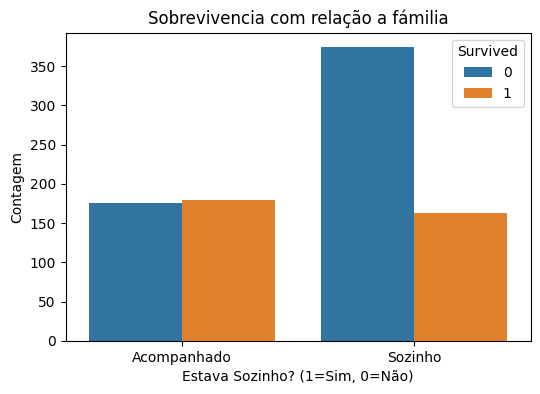

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x='IsAlone', hue='Survived', data=df_train, palette={0: '#1f77b4', 1: '#ff7f0e'})

plt.title('Sobrevivencia com relação a fámilia')
plt.xlabel('Estava Sozinho? (1=Sim, 0=Não)')
plt.ylabel('Contagem')
plt.xticks([0,1], ['Acompanhado', 'Sozinho'])

plt.show()

Analisando as colunas

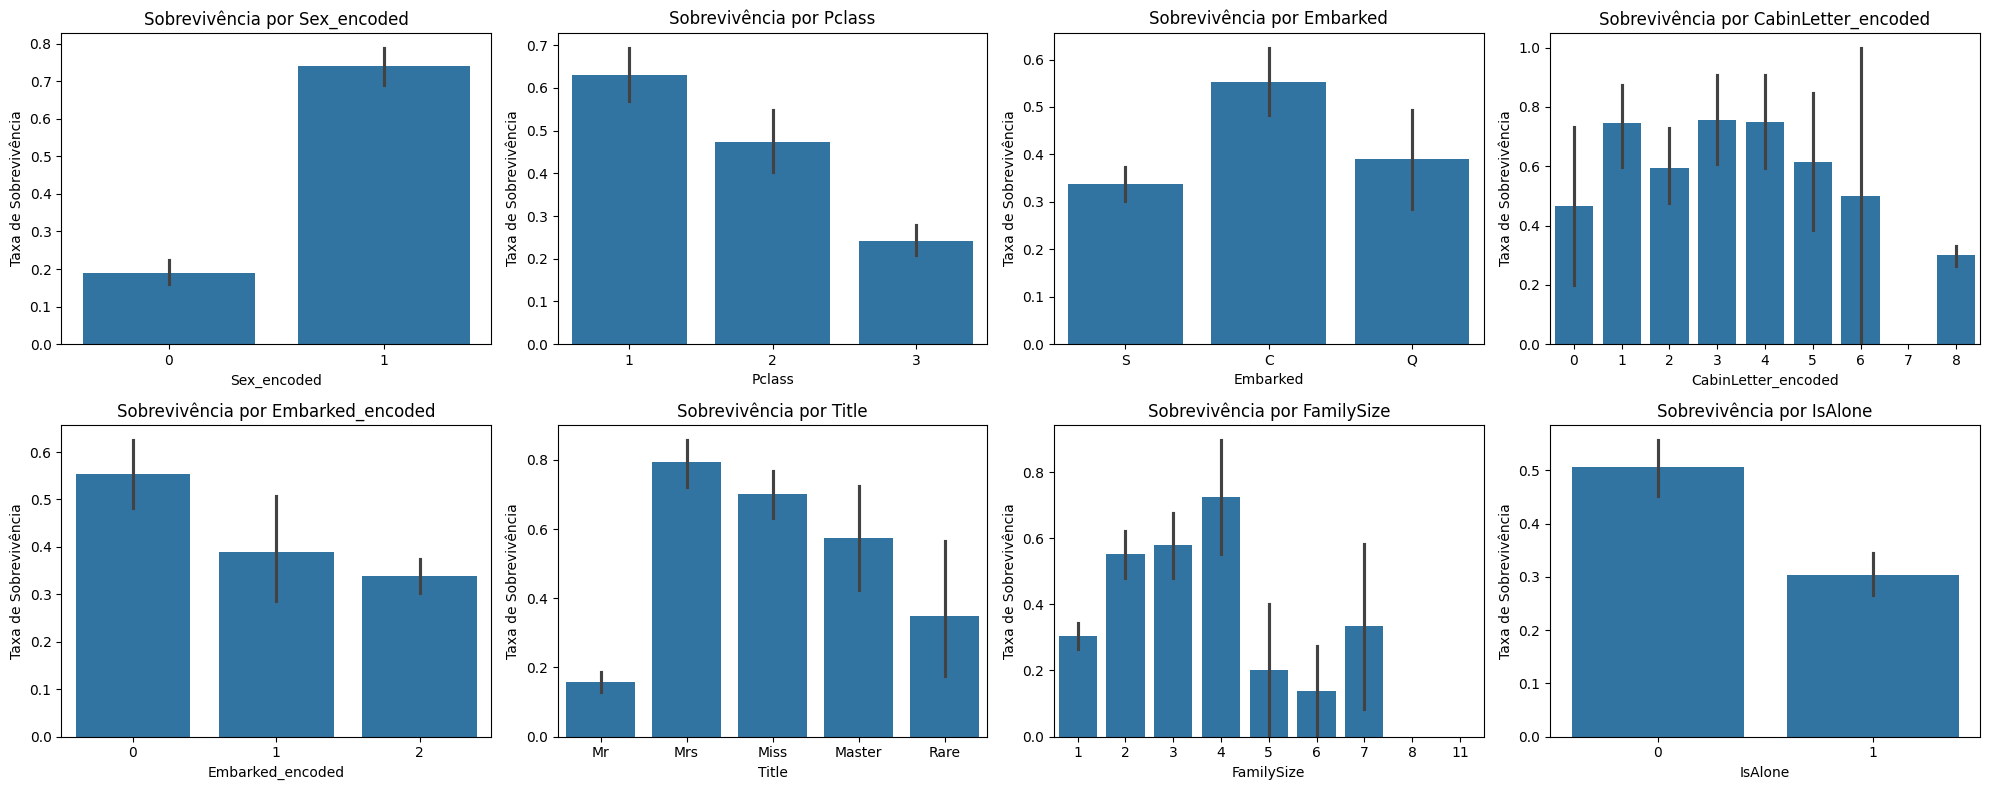

In [29]:
# Lista de colunas categóricas
categorical_features = ['Sex_encoded', 'Pclass', 'Embarked', 'CabinLetter_encoded', 
                        'Embarked_encoded', 'Title', 'FamilySize', 'IsAlone']

# Criar figura com 2 linhas e 4 colunas
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Gerar os gráficos
for i, feature in enumerate(categorical_features):
    row = i // 4
    col = i % 4
    sns.barplot(x=feature, y='Survived', data=df_train, ax=axes[row][col])
    sns.dark_palette("#69d", reverse=True, as_cmap=True)
    axes[row][col].set_title(f'Sobrevivência por {feature}')
    axes[row][col].set_ylabel('Taxa de Sobrevivência')

plt.tight_layout()
plt.show()

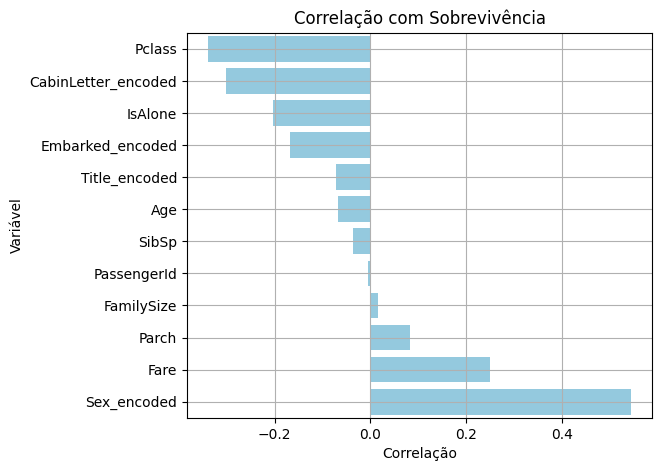

In [30]:
corr = df_train.corr(numeric_only=True)['Survived'].drop('Survived').sort_values()

plt.figure(figsize=(6, 5))
sns.barplot(x=corr.values, y=corr.index, color='skyblue')
plt.title('Correlação com Sobrevivência')
plt.xlabel('Correlação')
plt.ylabel('Variável')
plt.grid(True)
plt.show()

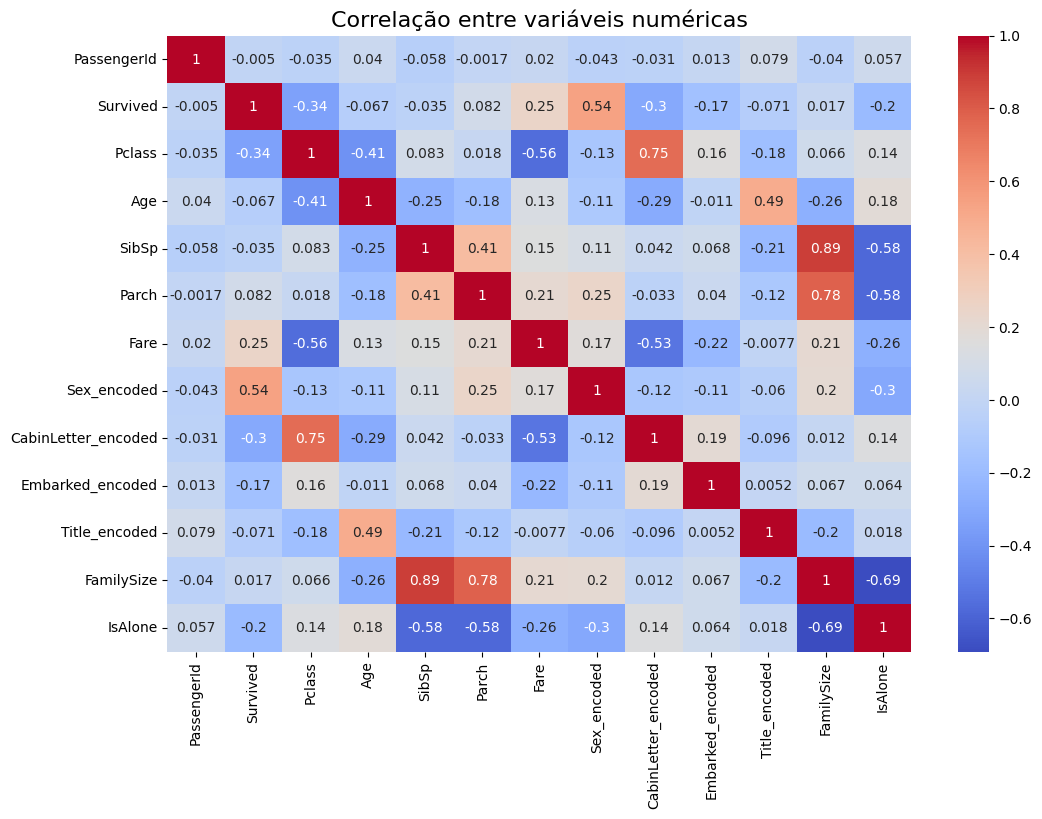

In [31]:
# Aumentar o tamanho da figura
plt.figure(figsize=(12, 8))  # você pode ajustar os números conforme o necessário

# Heatmap da correlação
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap='coolwarm')

# Título
plt.title('Correlação entre variáveis numéricas', fontsize=16)

# Mostrar gráfico
plt.show()

### **Modeling**

In [32]:
# Definição das variáveis e colunas para treinamento
features = ['Pclass','Sex_encoded', 'FamilySize', 'Title_encoded']

#"Pclass", "Sex", "SibSp", "Parch" ->0.97
# 'Pclass','Sex_encoded', 'FamilySize', 'CabinLetter_encoded' -> 0.99
# 'Pclass','Sex_encoded', 'FamilySize', 'CabinLetter_encoded', 'Title_encoded' -> 0.98

In [33]:
# Variável alvo
y_train = df_train["Survived"]

In [34]:
# Variáveis preditoras (features)
X_train = df_train[features].copy()

In [35]:
# Define o dicionário com os hiperparâmetros que serão testados pelo GridSearch
params = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Cria o objeto GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5)

# Ajusta (treina) o GridSearch nos dados de treino
grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'max_depth': 3, 'min_samples_split': 2}


In [36]:
# Criar e treinar o modelo RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,     # Número de árvores na floresta
    max_depth=1,          # Profundidade máxima das árvores para evitar overfitting
    random_state=2,       # Para garantir reprodutibilidade
)

In [37]:
# Treinar o modelo com os dados de treino
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


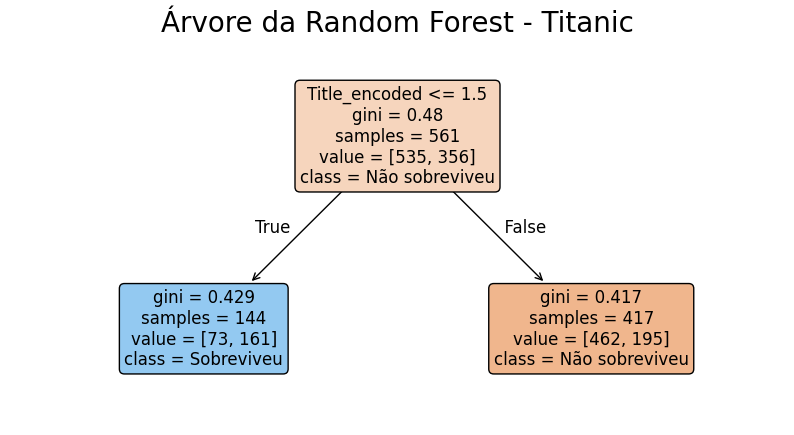

In [38]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 5))  # Aumenta o tamanho da imagem
plot_tree(
    model.estimators_[3],
    feature_names=X_train.columns,
    class_names=["Não sobreviveu", "Sobreviveu"],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Árvore da Random Forest - Titanic", fontsize=20)
plt.show()


### **Evaluation**

#### Ajustando os dados de teste

In [39]:
# Importando os dados de Teste
df_test = pd.read_csv('test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


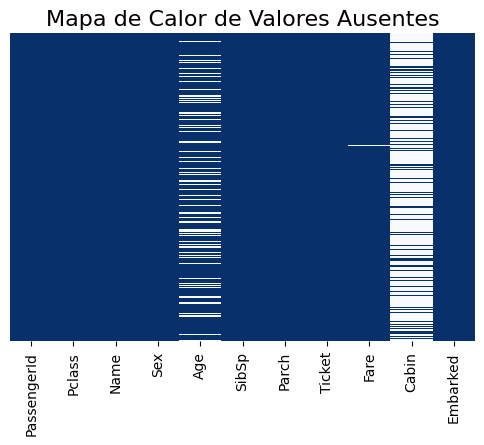

In [40]:
plt.figure(figsize=(6, 4))
sns.heatmap(df_test.isnull(), cbar=False, cmap='Blues_r', yticklabels=False)
plt.title('Mapa de Calor de Valores Ausentes', fontsize=16)
plt.show()

In [41]:
# Fazendo a Limpeza dos dados 
df_test['Sex_encoded'] = df_test['Sex'].replace({'male':0, 'female':1})

media_por_sex_test = df_test.groupby('Sex')['Age'].transform('mean')
df_test['Age']= df_test['Age'].fillna(media_por_sex_test)
df_test['Age'] = df_test['Age'].round().astype(int)

# Extrai a primeira letra da cabine, preenche os nulos com 'U' e codifica com LabelEncoder
df_test['CabinLetter_encoded'] = LabelEncoder().fit_transform(df_test['Cabin'].fillna('U').str[0])

# LabelEncoder em uma nova coluna, com os NaNs preenchidos diretamente no pipeline
le = LabelEncoder()
df_test['Embarked_encoded'] = le.fit_transform(df_test['Embarked'].fillna('S'))

# Calcular a mediana do grupo com mesma Pclass e Embarked
mediana_fare = df_test[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'S')]['Fare'].median()

# Preencher o valor ausente com essa mediana
df_test['Fare'] = df_test['Fare'].fillna(mediana_fare)

# Substituir valores zero pela média da mesma classe
for pclass in [1, 2, 3]:
    media_fare = df_test[(df_test['Pclass'] == pclass) & (df_test['Fare'] > 0)]['Fare'].mean()
    df_test.loc[(df_test['Pclass'] == pclass) & (df_test['Fare'] == 0), 'Fare'] = media_fare

# Extrair o título do nome
df_test['Title'] = df_test['Name'].str.extract(r',\s*([^\.]*)\.')

# Agrupar títulos semelhantes e reduzir ruído
title_mapping = {
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Lady': 'Rare',
    'Countess': 'Rare',
    'the Countess': 'Rare',  # <- Adicionado aqui
    'Capt': 'Rare',
    'Col': 'Rare',
    'Don': 'Rare',
    'Dr': 'Rare',
    'Major': 'Rare',
    'Rev': 'Rare',
    'Sir': 'Rare',
    'Jonkheer': 'Rare',
    'Dona': 'Rare'
}


df_test['Title'] = df_test['Title'].replace(title_mapping)

le = LabelEncoder()
df_test['Title_encoded'] = le.fit_transform(df_test['Title'])

df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
df_test['IsAlone'] = (df_test['FamilySize'] == 1).astype(int)

# Escolher as mesmas features usadas no treino
X_final_test = df_test[['Pclass','Age', 'Sex_encoded', 'FamilySize', 'Title_encoded']]

/var/folders/hd/4kr701xd78l014z49lq6j6j40000gn/T/ipykernel_14397/1793544834.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Sex_encoded'] = df_test['Sex'].replace({'male':0, 'female':1})


#### Arvore de decisão

In [42]:
# Carregar os dados 
gender_submission = pd.read_csv('gender_submission.csv')

In [43]:
# Preparar dados de teste
X_test = df_test[features].copy()

In [44]:
# Fazer previsões no conjunto de teste do Kaggle
y_pred = model.predict(X_test)

In [45]:
# Comparar com o arquivo gender_submission.csv
y_true = gender_submission["Survived"]

In [46]:
# Calcular acurácia
accuracy = accuracy_score(y_true, y_pred)
print(f"Acurácia final comparando com gender_submission.csv: {accuracy:.2f}")

Acurácia final comparando com gender_submission.csv: 1.00


In [47]:
# Relatório
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       152

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418



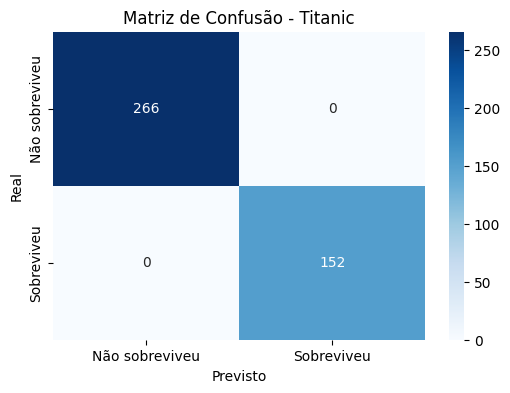

In [48]:
# Gera a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Plota a matriz de confusão com seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Não sobreviveu", "Sobreviveu"], yticklabels=["Não sobreviveu", "Sobreviveu"])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Titanic')
plt.show()

In [49]:
# Criar DataFrame com os dados de entrada e resultados
resultados_test = X_final_test.copy()
resultados_test['Real'] = y_true.values
resultados_test['Previsto'] = y_pred

# Filtrar os erros onde previu 0, mas era 1
erros_survived = resultados_test[(resultados_test['Real'] == 1) & (resultados_test['Previsto'] == 0)]

# Visualizar os erros
erros_survived

,Pclass,Age,Sex_encoded,FamilySize,Title_encoded,Real,Previsto


### Kaggle

In [50]:
# Criação do DataFrame para submissão
submission = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],  # use o PassengerId original do test.csv
    'Survived': resultados_test['Previsto']         # previsão do seu modelo (0 ou 1)
})

# Exportar para CSV (sem índice!)
submission.to_csv('submission.csv', index=False)

@misc{titanic,
    author = {Will Cukierski},
    title = {Titanic - Machine Learning from Disaster},
    year = {2012},
    howpublished = {\url{https://kaggle.com/competitions/titanic}},
    note = {Kaggle}
}